<a href="https://colab.research.google.com/github/yashvivaghela04/IMAGE-SIMILARITY-SEARCH-/blob/main/ViT_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# List the files in your Google Drive
drive_folder = "/content/drive/MyDrive"
files = os.listdir(drive_folder)

# Print out the files to find your ZIP file
print(files)

# Extract the ZIP file (make sure the correct path is used)
zip_file_path = "/content/drive/MyDrive/Jwellery data set.zip"  # Update with correct path
extraction_path = "/content/dataset"

# Extract the ZIP file
!unzip -o "$zip_file_path" -d "$extraction_path"

# Verify the extraction
!ls /content/dataset


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Jee adv maths', 'Jee adv chem', "Certi's", 'Daksh', 'BB', 'Untitled document.gdoc', 'Offer letter ', 'Colab Notebooks', 'Photo album.gslides', 'Untitled presentation.gslides', 'Next 24 tech internship ', 'Satellite Imagery project', 'Documentation.gdoc', 'Documentation for the Assignment.gdoc', 'Jwellery data set.zip', '011_012.png']
Archive:  /content/drive/MyDrive/Jwellery data set.zip
  inflating: /content/dataset/.gitattributes  
  inflating: /content/dataset/LICENSE  
  inflating: /content/dataset/README.md  
  inflating: /content/dataset/data/RingFIR/001/001_001.png  
  inflating: /content/dataset/data/RingFIR/001/001_002.png  
  inflating: /content/dataset/data/RingFIR/001/001_003.png  
  inflating: /content/dataset/data/RingFIR/001/001_004.png  
  inflating: /content/dataset/data/RingFIR/001/001_005.png  
  inflating: /content/dataset/data/RingFIR/0

In [ ]:
import os

# Step 1: Get All Image Paths from Subfolders
def get_all_image_paths(folder_path):
    valid_extensions = ('.png', '.jpg', '.jpeg')  # Define valid image extensions
    image_paths = []
    for root, _, files in os.walk(folder_path):  # Recursively go through all subfolders
        for file in files:
            if file.endswith(valid_extensions):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Define the path to the RingFIR folder
dataset_folder = r"/content/dataset/data/RingFIR"

# Extract all image paths
image_paths = get_all_image_paths(dataset_folder)
print(f"Extraction complete! Number of extracted images: {len(image_paths)}")


Extraction complete! Number of extracted images: 2605


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 22.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Valid images found: ['/content/dataset/data/RingFIR/002/002_036.png', '/content/dataset/data/RingFIR/002/002_003.png', '/content/dataset/data/RingFIR/002/002_005.png', '/content/dataset/data/RingFIR/002/002_038.png', '/content/dataset/data/RingFIR/002/002_019.png', '/content/dataset/data/RingFIR/002/002_010.png', '/content/dataset/data/RingFIR/002/002_028.png', '/content/dataset/data/RingFIR/002/002_026.png', '/content/dataset/data/RingFIR/002/002_002.png', '/content/dataset/data/RingFIR/002/002_037.png', '/content/dataset/data/RingFIR/002/002_020.png', '/content/dataset/data/RingFIR/002/002_035.png', '/content/dataset/data/RingFIR/002/002_023.png', '/content/dataset/data/RingFIR/002/002_022.png', '/content/dataset/data/RingFIR/002/002_033.png', '/content/dataset/data/RingFIR/002/002_014.png', '/content/dataset/data/RingFIR/002/002_042.png', '/content/dataset/data/RingFIR/002/002_025.png', '/content/dataset/data/RingFIR/002/002_013.png', '/content/dataset/data/RingFIR/002/002_034.png',

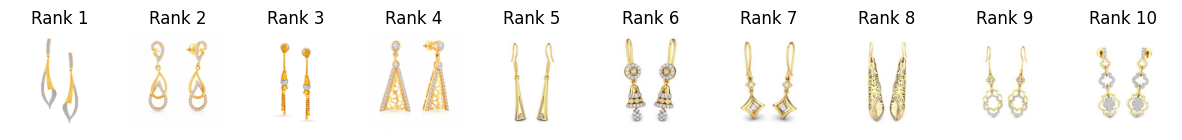

In [ ]:
!pip install transformers faiss-cpu torch torchvision opencv-python-headless numpy

import os
import cv2
import torch
import faiss
import numpy as np
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load and preprocess image
def load_and_preprocess_image(input_image, processor, image_size=224):
    image = cv2.imread(input_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_size, image_size))
    return processor(images=image, return_tensors="pt")['pixel_values']

# Extract embeddings
def extract_embeddings(input_image, model, processor):
    preprocessed_image = load_and_preprocess_image(input_image, processor)
    with torch.no_grad():
        outputs = model(preprocessed_image)
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Build FAISS index
def build_faiss_index(embeddings):
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(embeddings)
    return index

# Find similar images
def find_similar_images(input_embedding, index, k=10):
    distances, indices = index.search(input_embedding, k)
    return distances, indices

# Visualize top-k similar images
def display_images(image_paths):
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(image_paths):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Rank {i + 1}")
    plt.show()

# Main function to extract embeddings and find similar images
def main():
    input_image_path = "/content/dataset/data/RingFIR/002/002_001.png"  # Input query image
    top_k = 10  # Number of similar images to retrieve

    # Path to dataset folder containing images
    dataset_path = "/content/dataset/data/RingFIR/002"  # Ensure this points to the folder with multiple images

    # Validate paths
    if not os.path.exists(input_image_path):
        raise FileNotFoundError(f"Input image not found: {input_image_path}")
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset folder not found: {dataset_path}")

    # Load Vision Transformer model and processor
    model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
    processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

    # Get a list of images in the dataset folder
    dataset_images = [
        os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))
    ]

    if not dataset_images:
        raise ValueError(f"No valid images found in folder: {dataset_path}")

    print(f"Valid images found: {dataset_images}")

    # Extract embeddings for database images
    print("Extracting embeddings for database images...")
    db_embeddings = np.vstack([extract_embeddings(img, model, processor) for img in dataset_images])

    # Build FAISS index
    print("Building FAISS index...")
    faiss_index = build_faiss_index(db_embeddings)

    # Extract embedding for the input image
    print(f"Extracting embedding for input image: {input_image_path}")
    input_embedding = extract_embeddings(input_image_path, model, processor)

    # Find similar images using FAISS
    print("Finding similar images...")
    distances, indices = find_similar_images(input_embedding, faiss_index, top_k)

    # Get paths of top-k similar images
    similar_images = [dataset_images[idx] for idx in indices[0]]
    print(f"Top {top_k} similar images:", similar_images)

    # Visualize top-k similar images
    display_images(similar_images)

    return similar_images

# Run the main function
if __name__ == "__main__":
    top_similar_images = main()
